# Projeto: Previsão de Movimentação de Cargas no Porto de Santos

**Autor**: Leonardo de Jesus Andrade<br>
**Data:** 20/06/2025<br>

## 1. Contexto
O Porto de Santos é o maior complexo portuário da América Latina e um termômetro da economia brasileira. A gestão eficiente do seu imenso fluxo de cargas é um desafio logístico complexo, onde a capacidade de prever a demanda futura é um diferencial competitivo crucial.

## 2. Objetivo
O objetivo deste notebook é desenvolver um projeto completo de ciência de dados para prever a movimentação mensal de toneladas no Porto de Santos de 2022 a 2025. Para isso, vamos explorar dados históricos, testar o impacto de diferentes variáveis (incluindo dados climáticos, como a pluviometria mensal) e comparar múltiplos modelos de machine learning para encontrar a solução mais precisa.

## 3. Dataset
Os dados utilizados nesse projeto foram compostos por:
* **Dados Operacionais:** Registros históricos do Porto de Santos contendo informações sobre a carga (`Natureza da Carga`), tipo de operação (`Tipo_movimento`, `Navegação`), etc.
* **Dados Climáticos:** Dados de pluviometria para a cidade de Santos, coletados via web scraping para testar a hipótese de que o clima impacta a operação.

## 4. Plano de Ação
Este notebook seguirá os seguintes passos:
1.  **Limpeza dos dados / feature engineering:** Limpar os dados e criar novas variáveis para os modelos.
2.  **Análise Exploratória dos Dados (EDA):** Investigar padrões, tendências e sazonalidades.
4.  **Modelagem Preditiva:** Treinar e comparar o desempenho de diferentes modelos.
5.  **Avaliação e Análise de Resultados:** Interpretar os resultados do melhor modelo e extrair conclusões.

In [3]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

In [4]:
plt.style.use('seaborn-v0_8-darkgrid')

# **Limpeza dos dados / feature engineering**

### **Dataset**

#### 1. Porto-Dataset
Este dataset contém os registros históricos de movimentação de cargas no Porto de Santos. Cada linha representa uma operação específica.<br>
* **Ano:** Ano em que a operação foi realizada.<br>
* **Mes:** Mes em que a operação foi realizada.<br>
* **DESC_SIMPLES:** Descrição do local da operação.<br>
* **TIPO_INSTALAÇÂO (grupos):** Classifica o tipo de terminal portuário onde a operação ocorreu, segundo a regulamentação brasileira.<br>
* **Terminal - Gerin:** Indica o operador do terminal.<br>
* **naturezacarga:** A categoria geral da carga movimentada.
    * _Exemplos: `GRANEL SOLIDO`, `GRANEL LIQUIDO`, `CARGE GERAL`._ <br>
* **TIPO_MOVIMENTO:** Descreve a forma como a movimentação da carga foi realizada no cais.
* **navegação:** Define o tipo da rota da embarcação.
    * `LONGO CURSO`: Navegação internacional (entre portos brasileiros).
    * `CABOTAGEM`: Indica a direção do fluxo da carga. <br>
* **Sentido_carga:** Indica se a carga está embarcando ou desembarcando.<br>
* **desc_spa:** A descrição específica do produto ou mercadoria movimentada.
    * _Exemplos: `AÇÚCAR`, `GASOLINA`, `BUNKER(DIESEL)`_. <br>
* **Toneladas:** Peso total da carga, medido em toneladas métricas (1.000 kg).<br>
* **TEUs:** É uma capacidade de volume, usada para padronizar o tamanho dos contêineres.<br>
* **Unidades:** Representa a quantidade de itens discretos que foram movimentados. É uma contagem de objetos individuais.<br>

#### 2. Dados de Pluviometria
Este dataset contém os registros diários de chuva para a cidade de Santos, usados para investigar a correlação entre o clima e a operação portuária.<br>

* **Data da Medição:** Dia, mês e ano em que a medição foi realizada.<br>
* **Indíce Pluviometrico:** A quantidade de chuva acumulada no dia, medida em milímetros (mm). Um índice de 10 mm significa um acúmulo de 10 litros de água por metro quadrado.<br>

_Nota_: _Os dados foram extraídos via técnicas de web scraping do portal da Prefeitura de Santos e consolidados em um arquivo CSV. Os dados brutos podem ser consultados [neste link](https://www.santos.sp.gov.br/?q=pluviometria-tabela&field_data_medicao=2025-01)._

In [5]:
df_pluviometrico = pd.read_csv('/kaggle/input/pluviometria/dados_meteorologicos (1).csv', encoding='utf-8', sep=',')

In [6]:
df = pd.DataFrame()
datasets_dir = '/kaggle/input/porto-dataset/'
for csv_path in os.listdir(datasets_dir):
    single_df = pd.read_csv(datasets_dir + csv_path, encoding='utf-8', sep=';') 
    df = pd.concat([df, single_df])
df

,Ano,Mês,DESC_SIMPLES,TIPO_INSTALAÇÃO (grupos),Terminal - GERIN,naturezacarga,TIPO_MOVIMENTO,navegacao,Sentido_carga,desc_spa,Toneladas,TEUs,Unidades
0,2015.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (DIESEL),507.000,-,-
1,2015.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,CABOTAGEM,EMBARQUE,BUNKER (O.COMBUS,28.056,-,-
2,2015.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (DIESEL),2.028,-,-
3,2015.0,1.0,ABST.EMBARCACAO,PORTO ORGANIZADO,OUTROS,GRANEL LIQUIDO,CONTRABORDO,LONGO CURSO,EMBARQUE,BUNKER (O.COMBUS,112.226,-,-
4,2015.0,1.0,ALAMOA 1,PORTO ORGANIZADO,TRANSPETRO,GRANEL LIQUIDO,CONVENCIONAL,CABOTAGEM,EMBARQUE,GASOLINA,65.968,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,2017.0,12.0,TIPLAM 3,TUP,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,EMBARQUE,AÇÚCAR,159.739,-,-
15308,2017.0,12.0,USIMINAS 3,TUP,USIMINAS,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,PRODUTOS SIDERÚR,48.251,-,3.040
15309,2017.0,12.0,USIMINAS 4,TUP,USIMINAS,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,PRODUTOS SIDERÚR,4.290,-,227
15310,2017.0,12.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,EMBARQUE,FERTILIZANTES NI,460.000,32,16


In [7]:
df_mean_pluv = df_pluviometrico.groupby(['Ano', 'Mes'])['Indíce Pluviometrico'].mean()
df_mean_pluv = pd.DataFrame(df_mean_pluv).reset_index()

In [8]:
df['naturezacarga'].unique()

array(['GRANEL LIQUIDO', 'GRANEL SOLIDO', 'CARGA GERAL',
       'CARGA CONTEINERIZADA', nan], dtype=object)

In [9]:
df.tail()

,Ano,Mês,DESC_SIMPLES,TIPO_INSTALAÇÃO (grupos),Terminal - GERIN,naturezacarga,TIPO_MOVIMENTO,navegacao,Sentido_carga,desc_spa,Toneladas,TEUs,Unidades
15307,2017.0,12.0,TIPLAM 3,TUP,TIPLAM,GRANEL SOLIDO,CONVENCIONAL,LONGO CURSO,EMBARQUE,AÇÚCAR,159.739,-,-
15308,2017.0,12.0,USIMINAS 3,TUP,USIMINAS,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,PRODUTOS SIDERÚR,48.251,-,3.040
15309,2017.0,12.0,USIMINAS 4,TUP,USIMINAS,CARGA GERAL,CONVENCIONAL,LONGO CURSO,EMBARQUE,PRODUTOS SIDERÚR,4.290,-,227
15310,2017.0,12.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,EMBARQUE,FERTILIZANTES NI,460.000,32,16
15311,2017.0,12.0,VALONGO,PORTO ORGANIZADO,ECOPORTO,CARGA CONTEINERIZADA,CONVENCIONAL,LONGO CURSO,EMBARQUE,OUTRAS MERCADORI,1.560,88,88


In [10]:
df.shape

(155368, 13)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155368 entries, 0 to 15311
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Ano                       155350 non-null  float64
 1   Mês                       155350 non-null  float64
 2   DESC_SIMPLES              155350 non-null  object 
 3   TIPO_INSTALAÇÃO (grupos)  155350 non-null  object 
 4   Terminal - GERIN          155350 non-null  object 
 5   naturezacarga             155350 non-null  object 
 6   TIPO_MOVIMENTO            155350 non-null  object 
 7   navegacao                 155350 non-null  object 
 8   Sentido_carga             155350 non-null  object 
 9   desc_spa                  155350 non-null  object 
 10   Toneladas                155350 non-null  float64
 11   TEUs                     155350 non-null  object 
 12   Unidades                 155350 non-null  object 
dtypes: float64(3), object(10)
memory usage: 16.6+ MB


In [12]:
df = df.rename(columns={'Mês': 'Mes'})

In [13]:
for column in df.columns:
    print(f'{column} : Valores nulos {df[column].isna().sum()}')

Ano : Valores nulos 18
Mes : Valores nulos 18
DESC_SIMPLES : Valores nulos 18
TIPO_INSTALAÇÃO (grupos) : Valores nulos 18
Terminal - GERIN : Valores nulos 18
naturezacarga : Valores nulos 18
TIPO_MOVIMENTO : Valores nulos 18
navegacao : Valores nulos 18
Sentido_carga : Valores nulos 18
desc_spa : Valores nulos 18
 Toneladas  : Valores nulos 18
 TEUs  : Valores nulos 18
 Unidades  : Valores nulos 18


In [14]:
all_na_rows = df[df.isna().all(axis=1)]
print(f"\nLinhas onde todas as colunas sao NaN: {len(all_na_rows)}")
if len(all_na_rows) > 0:
    print(f'Indice das linhas com todos os valores nulos: {all_na_rows.index}')


Linhas onde todas as colunas sao NaN: 18
Indice das linhas com todos os valores nulos: Index([16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281,
       16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289],
      dtype='int64')


In [15]:
df.iloc[125012]

Ano                         NaN
Mes                         NaN
DESC_SIMPLES                NaN
TIPO_INSTALAÇÃO (grupos)    NaN
Terminal - GERIN            NaN
naturezacarga               NaN
TIPO_MOVIMENTO              NaN
navegacao                   NaN
Sentido_carga               NaN
desc_spa                    NaN
 Toneladas                  NaN
 TEUs                       NaN
 Unidades                   NaN
Name: 16272, dtype: object

In [16]:
df = df.dropna()
df.isna().sum()

Ano                         0
Mes                         0
DESC_SIMPLES                0
TIPO_INSTALAÇÃO (grupos)    0
Terminal - GERIN            0
naturezacarga               0
TIPO_MOVIMENTO              0
navegacao                   0
Sentido_carga               0
desc_spa                    0
 Toneladas                  0
 TEUs                       0
 Unidades                   0
dtype: int64

In [17]:
# Remove o espaço no nome das colunas.
df = df.rename(columns={' Toneladas ': 'Toneladas', ' TEUs ': 'TEUs', ' Unidades ': 'Unidades'})

# Alterando o tipo das variáveis 'Ano' e 'Mes'
df['Ano'] = df['Ano'].astype(int)
df['Mes'] = df['Mes'].astype(int)

In [18]:
unique_vals = df['TEUs'].astype(str).value_counts()
print(unique_vals)

TEUs
-          20680
2          13846
1           7289
4           7186
6           4630
           ...  
10.372         1
3.936          1
4.369          1
10.010         1
2.432          1
Name: count, Length: 7427, dtype: int64


In [19]:
"""
O Código abaixo altera os valores das colunas 'TEUs' e 'Unidades' quando o valor é '-',
e altera para 0. O valor '-' indica que a quantidade de TEUs ou Unidades não pode ser medida.
"""


df['TEUs'] = (df['TEUs']
                .astype(str)
                .str.strip()
                .replace(['-', ' - ', '--', ''], np.nan)
                .fillna(0)
                .astype(float)
                )

df['Unidades'] = (df['Unidades']
                  .astype(str)
                  .str.strip()
                  .replace(['-', ' - ', '--', ''], np.nan)
                  .str.replace(r'\.', '', regex=True)
                  .replace('nan', np.nan)
                  .pipe(pd.to_numeric, errors='coerce')
                  .fillna(0)
                 )

In [20]:
linhas_duplicadas = df.duplicated().sum()
print(linhas_duplicadas)

0


In [21]:
# Ordenando por ano e mês.
df = df.sort_values(by=['Ano', 'Mes'])

In [22]:
# Mesclando o dataset de pluviometria com o dataset do porto de Santos através das colunas 'Ano' e 'Mes'.
df = pd.merge(df, df_mean_pluv, on=['Ano', 'Mes'])
df.rename(columns={'Indíce Pluviometrico': 'Indice_pluv_media'}, inplace=True)

In [23]:
# Salvando o novo dataframe
df.to_csv('APS_COMPLETO.csv', index=False, encoding='utf-8')

# **Análise Exploratória (EDA)**

In [24]:
df.describe()

,Ano,Mes,Toneladas,TEUs,Unidades,Indice_pluv_media
count,49816.000000,49816.000000,49816.000000,49816.000000,4.981600e+04,49816.000000
mean,2023.110487,6.335736,148.096640,65.167334,9.775483e+02,7.199373
std,0.910662,3.515989,220.418149,157.973914,1.709492e+04,4.182454
min,2022.000000,1.000000,0.000000,0.000000,0.000000e+00,1.612903
25%,2022.000000,3.000000,9.168000,2.000000,2.000000e+00,4.170968
50%,2023.000000,6.000000,41.633500,6.148500,2.000000e+01,5.893333
75%,2024.000000,9.000000,188.000000,37.000000,1.740000e+02,10.450000
max,2025.000000,12.000000,999.000000,999.000000,2.020308e+06,18.838710


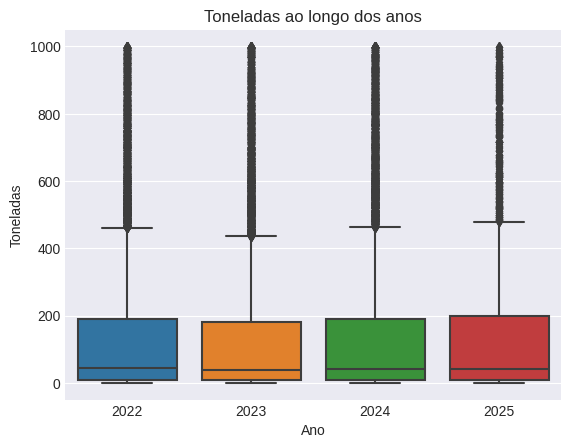

In [25]:
plt.title('Toneladas ao longo dos anos')
sns.boxplot(data=df, y='Toneladas', x='Ano')
plt.show()

<Axes: >

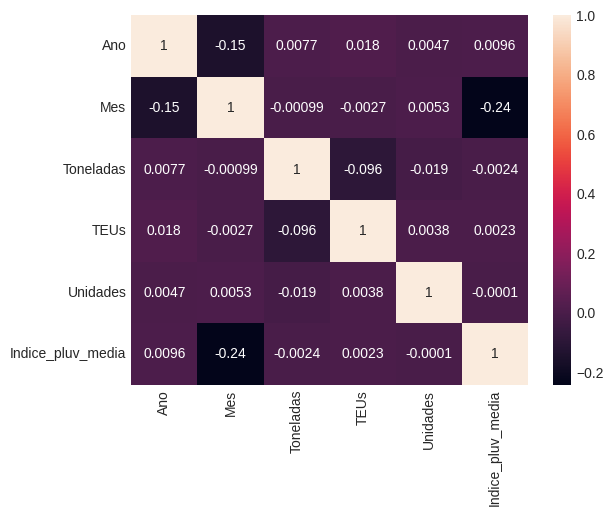

In [26]:
sns.heatmap(df.select_dtypes('number').corr(), annot=True)

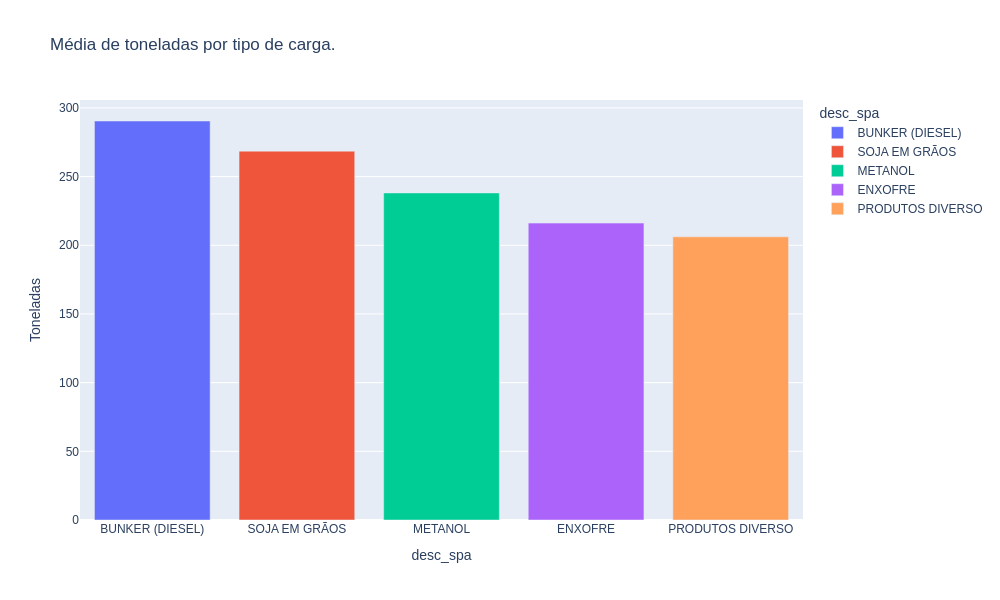

In [27]:
top_cargas = pd.DataFrame(df.groupby('desc_spa')['Toneladas'].mean()).reset_index().sort_values(by='Toneladas', ascending=False).head(5)

fig = px.bar(top_cargas, x='desc_spa', y='Toneladas', title='Média de toneladas por tipo de carga.', color='desc_spa')

fig.show()

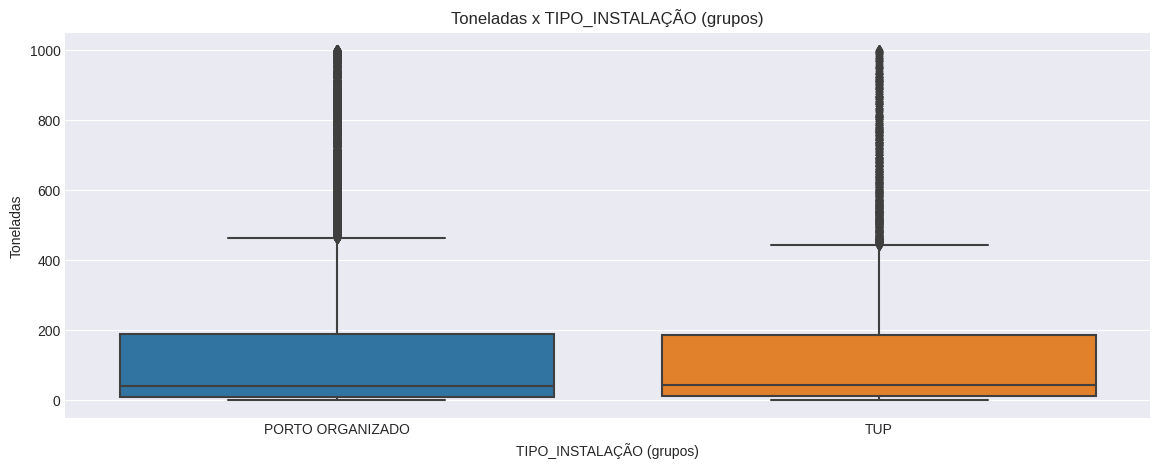

,count,mean,std,min,25%,50%,75%,max
TIPO_INSTALAÇÃO (grupos),,,,,,,,
PORTO ORGANIZADO,37314.0,149.292536,222.836273,0.0,8.46050,41.0,190.00000,999.0
TUP,12502.0,144.527320,213.006562,0.0,11.51325,44.0,184.47325,999.0


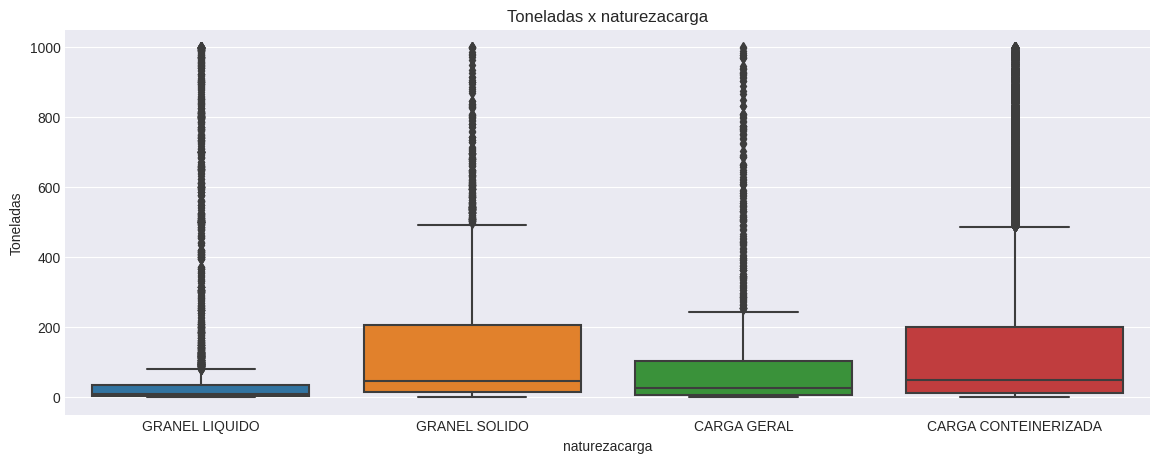

,count,mean,std,min,25%,50%,75%,max
naturezacarga,,,,,,,,
CARGA CONTEINERIZADA,42274.0,154.263069,221.607777,1.0,11.0000,49.0000,201.000,999.0
GRANEL LIQUIDO,3649.0,95.247523,219.828954,0.0,3.4830,10.0160,33.762,999.0
GRANEL SOLIDO,2353.0,148.053479,204.323003,1.0,14.0200,47.2090,205.448,999.0
CARGA GERAL,1540.0,104.115079,188.931327,0.0,5.0895,25.1735,102.000,999.0


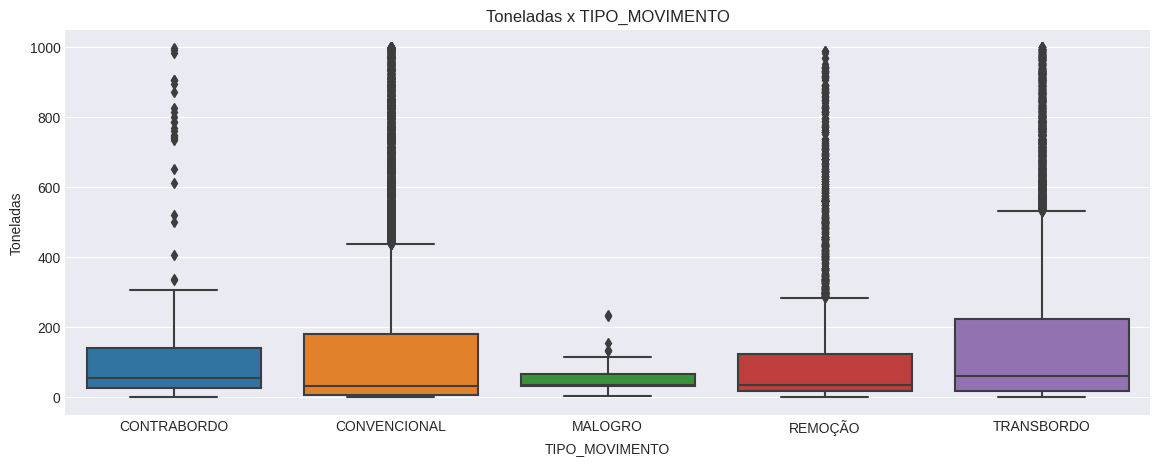

,count,mean,std,min,25%,50%,75%,max
TIPO_MOVIMENTO,,,,,,,,
CONVENCIONAL,27797.0,144.543223,225.237590,0.000,6.3460,32.0000,179.000,999.0
TRANSBORDO,17205.0,162.392739,220.502120,0.000,17.6310,61.0000,223.000,999.0
REMOÇÃO,4597.0,116.213577,182.487972,1.006,16.0000,34.0000,123.000,988.0
CONTRABORDO,158.0,178.825297,267.351713,1.028,26.8025,53.9245,140.696,996.0
MALOGRO,59.0,55.237288,45.432913,4.000,32.0000,34.0000,66.000,234.0


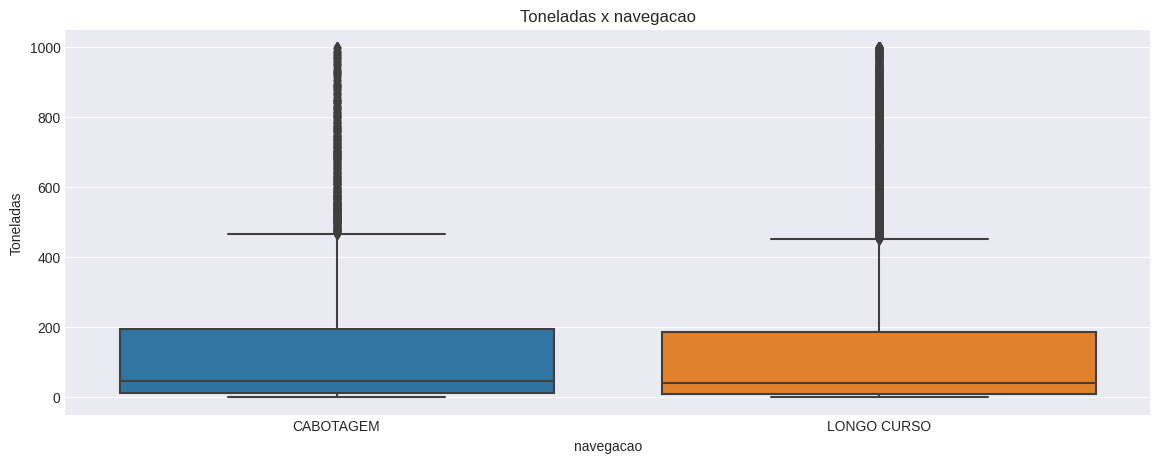

,count,mean,std,min,25%,50%,75%,max
navegacao,,,,,,,,
LONGO CURSO,37162.0,147.590611,221.378024,0.0,8.80875,39.6030,186.0,999.0
CABOTAGEM,12654.0,149.582738,217.576600,0.0,11.27800,46.0615,193.0,999.0


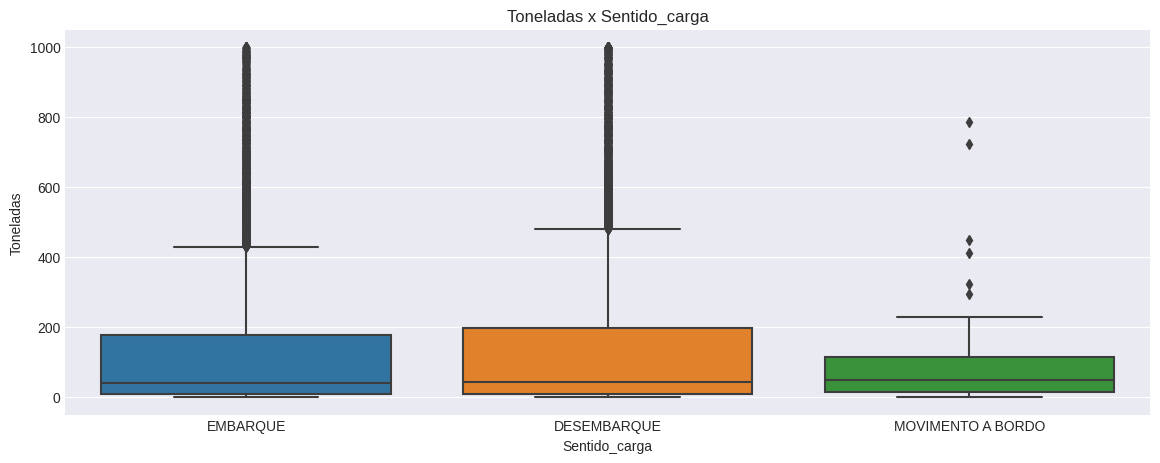

,count,mean,std,min,25%,50%,75%,max
Sentido_carga,,,,,,,,
EMBARQUE,24955.0,143.953649,216.828706,0.000,9.00000,40.0,177.0,999.0
DESEMBARQUE,24802.0,152.372668,224.015882,0.000,9.57325,43.0,198.0,999.0
MOVIMENTO A BORDO,59.0,102.915356,156.564923,1.006,15.50000,49.0,114.5,784.0


In [28]:
nunique_str_cols = df.select_dtypes('object').nunique()
nunique_str_cols = nunique_str_cols[nunique_str_cols <= 5].index
for col in nunique_str_cols:
    plt.figure(figsize=(14, 5))
    plt.title(f'Toneladas x {col}')
    sns.boxplot(data=df, x=col, y='Toneladas')
    plt.show()
    display(df.groupby(col)['Toneladas'].describe().sort_values(by='count', ascending=False))

In [29]:
df_pluv_per_date = df.groupby(['Ano', 'Mes'])['Indice_pluv_media'].mean().reset_index()

# 2. Criando coluna de data
df_pluv_per_date['Data'] = pd.to_datetime(df_pluv_per_date['Ano'].astype(str) + '-' + df_pluv_per_date['Mes'].astype(str) + '-01')

# 3. Ordenar por data (opcional mas recomendado)
df_pluv_per_date = df_pluv_per_date.sort_values('Data')

# 4. Plot da série temporal
#plt.figure(figsize=(14, 5))
fig = px.line(df_pluv_per_date, 
              x='Data', 
              y='Indice_pluv_media', 
              title='Índice pluviométrico ao longo dos anos (2022 - 2025)',
              text='Mes')
fig.update_traces(textposition='bottom right')

fig.show()

/tmp/ipykernel_35/3677165218.py:5: UserWarning:

The figure layout has changed to tight



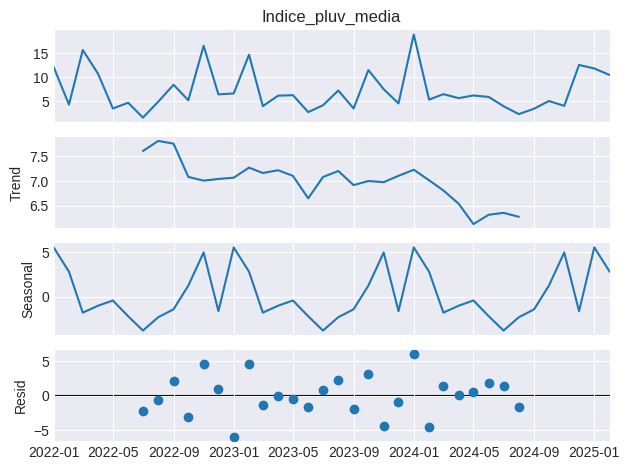

In [30]:
df_pluv = df_pluv_per_date.set_index('Data')
df_pluv = df_pluv.asfreq('MS')
decomposition = seasonal_decompose(df_pluv['Indice_pluv_media'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

In [31]:
df_tons_per_date = df.groupby(['Ano', 'Mes'])['Toneladas'].sum().reset_index()

# 2. Criando coluna de data
df_tons_per_date['Data'] = pd.to_datetime(df_tons_per_date['Ano'].astype(str) + '-' + df_tons_per_date['Mes'].astype(str) + '-01')

# 3. Ordenar por data (opcional mas recomendado)
df_tons_per_date = df_tons_per_date.sort_values('Data')

# 4. Plot da série temporal
fig = px.line(df_tons_per_date, 
              x='Data', 
              y='Toneladas', 
              title='Movimentação de toneladas ao longo dos anos (2022 - 2025)',
              text='Mes')
fig.update_traces(textposition='bottom right')

fig.show()

Em janeiro de 2023, o Porto de Santos teve uma queda de movimentação por conta da redução nos embarques de soja e nas descargas de fertilizantes, segundo a Autoridade Portuária de Santos (APS).

_**Fonte:** [Movimentação de açúcar volta a se destacar no Porto de Santos em janeiro](https://www.portodesantos.com.br/2023/02/24/movimentacao-de-acucar-volta-a-se-destacar-no-porto-de-santos-em-janeiro/#:~:text=O%20movimento%20geral%20em%20janeiro,que%20atingiram%2057%2C4%25.)_

/tmp/ipykernel_35/2878649215.py:5: UserWarning:

The figure layout has changed to tight



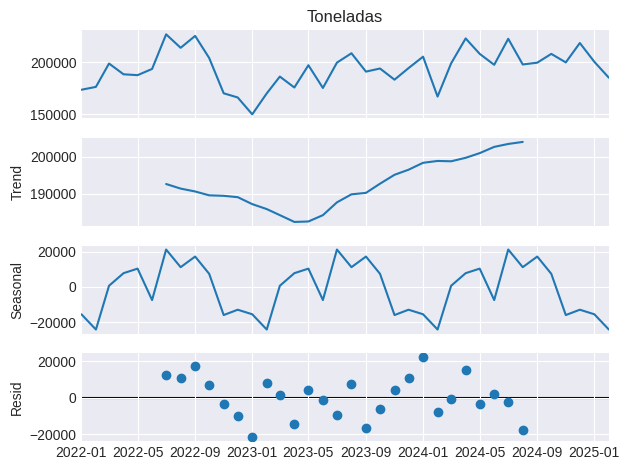

In [32]:
df_ts = df_tons_per_date.set_index('Data')
df_ts = df_ts.asfreq('MS')
decomposition = seasonal_decompose(df_ts['Toneladas'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

A análise da série de toneladas mostra que houve uma queda entre o começo de 2022 e a metade de 2023, seguida de uma recuperação gradual até 2024. Isso pode estar ligado a fatores como economia, clima ou operação, que influenciaram a movimentação nesse período.

A parte sazonal da série apresenta variações regulares ao longo dos meses, indicando que há um padrão repetitivo todo ano. Os resíduos (diferença entre os valores reais e os ajustados) são pequenos e sem um padrão claro, o que mostra que o modelo usado conseguiu explicar bem os dados com a tendência e a sazonalidade.

In [33]:
stat, p_value, _, _ = ts.kpss(df_ts['Toneladas'], regression='c')  # 'c' para testar tendência
print(f'KPSS p-valor: {p_value}')

if p_value < 0.05:
    print("A série NÃO é estacionária → Possível presença de tendência.")
else:
    print("A série é estacionária → Provavelmente sem tendência.")


KPSS p-valor: 0.1
A série é estacionária → Provavelmente sem tendência.


/tmp/ipykernel_35/2728487509.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




# **Preparação de Dados**

In [34]:
# Identificando Outliers
Q1 = df['Toneladas'].quantile(0.25)
Q3 = df['Toneladas'].quantile(0.75)

# Intervalo Interquartil
IQR =  Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Removendo outliers
df = df[(df['Toneladas'] >= lower_limit) & (df['Toneladas'] <= upper_limit)]

In [35]:
df_groupped = df.groupby(['Ano', 'Mes', 'TIPO_INSTALAÇÃO (grupos)', 'naturezacarga', 'TIPO_MOVIMENTO', 'navegacao', 'Sentido_carga']).agg({
    'Toneladas': 'sum',
    'Indice_pluv_media': 'mean'
}).reset_index()
str_cols = df_groupped.select_dtypes('object').columns
for col in str_cols:
    df_groupped[col] = LabelEncoder().fit_transform(df_groupped[col])
X, Y = df_groupped.drop('Toneladas', axis=1), df_groupped['Toneladas']
train_samples = math.floor(len(X) * 0.8)
test_samples = len(X) - train_samples
X_train, X_test, Y_train, Y_test = X.head(train_samples), X.tail(test_samples), Y.head(train_samples), Y.tail(test_samples)

# **Modelos**

In [36]:
metrics = []

## Random Forest

In [37]:
rf_model = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)
best_rf_model = grid_search.best_estimator_
Y_pred = best_rf_model.predict(X_test)

In [38]:
zeros_em_y_test = (Y_test == 0).sum()

print(f"Número de valores iguais a zero em Y_test: {zeros_em_y_test}")

Número de valores iguais a zero em Y_test: 3


In [39]:
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test, Y_pred) * 100

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAPE: {mape:.2f}")
metrics.append({ 'model': 'Random Forest', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 410365.85
RMSE: 640.60
MAE: 396.46
R²: 0.95
MAPE: 185496365968174144.00


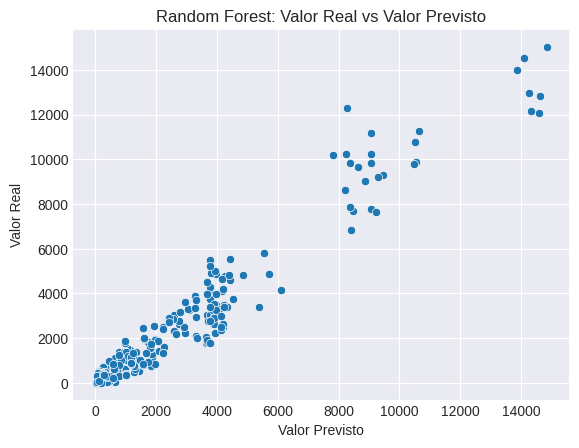

In [40]:
sns.scatterplot(y=Y_test, x=Y_pred)
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('Random Forest: Valor Real vs Valor Previsto')
plt.show()

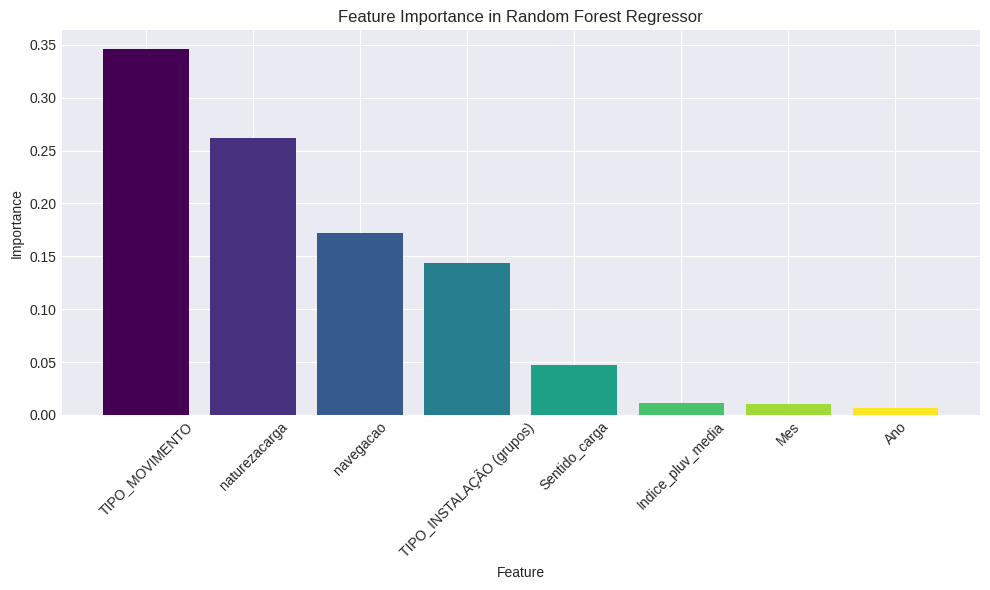

In [41]:
feature_names = [f"{i}" for i in X.columns]
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

num_features = len(feature_names)
colors = plt.cm.viridis(np.linspace(0, 1, num_features))

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors)
plt.xticks(range(X.shape[1]), np.array(feature_names)[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Regressor")

plt.grid(True)
plt.tight_layout()
plt.show()


## XGBoost

In [42]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_xgb.fit(X_train, Y_train)

# Resultados
best_xgb_model = grid_xgb.best_estimator_
Y_pred = best_xgb_model.predict(X_test)

In [43]:
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
metrics.append({ 'model': 'XGBoost', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 364677.62
RMSE: 603.89
MAE: 401.62
R²: 0.95


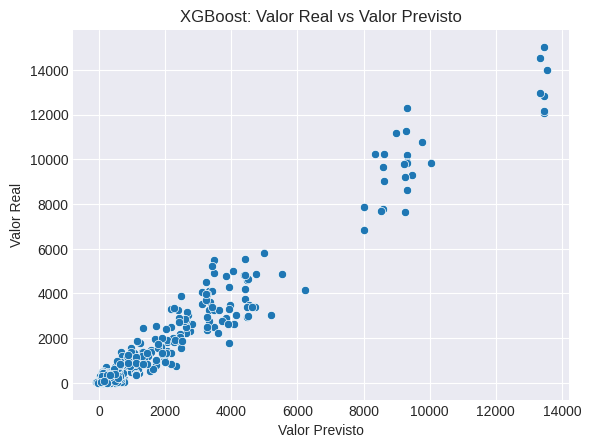

In [44]:
sns.scatterplot(y=Y_test, x=Y_pred)
plt.xlabel('Valor Previsto')
plt.ylabel('Valor Real')
plt.title('XGBoost: Valor Real vs Valor Previsto')
plt.show()

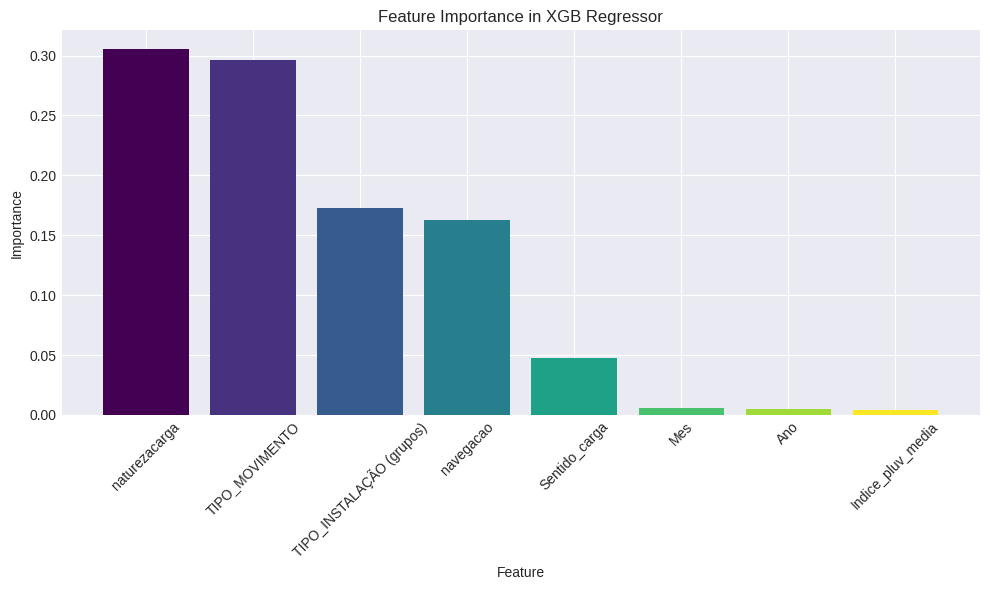

In [45]:
feature_names = [f"{i}" for i in X.columns]
importances = best_xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align="center", color=colors)
plt.xticks(range(X.shape[1]), np.array(feature_names)[indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in XGB Regressor")

plt.grid(True)
plt.tight_layout()
plt.show()


## Arima

In [46]:
time_serie = df_groupped.groupby(['Ano', 'Mes'])['Toneladas'].sum().reset_index()
exog = df_groupped.groupby(['Ano', 'Mes'])['Indice_pluv_media'].mean().reset_index()
time_serie

,Ano,Mes,Toneladas
0,2022,1,88447.507
1,2022,2,87426.531
2,2022,3,97258.279
3,2022,4,102496.869
4,2022,5,89522.736
5,2022,6,96138.460
6,2022,7,104245.312
7,2022,8,100197.461
8,2022,9,113156.630
9,2022,10,101865.471


In [47]:
train_time_serie = time_serie['Toneladas'][:-12]  # tudo menos os últimos 12 meses
test_time_serie = time_serie['Toneladas'][-12:]
train_exog = exog[:-12]
test_exog = exog[-12:]

In [48]:
arima_model = ARIMA(train_time_serie, order=(1, 1, 1))  # (p,d,q)
model_fit = arima_model.fit()
forecast = model_fit.forecast(steps=12)
Y_pred = pd.Series(forecast, index=test_time_serie.index)

In [49]:
mse = mean_squared_error(test_time_serie, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_time_serie, Y_pred)
r2 = r2_score(test_time_serie, Y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
metrics.append({ 'model': 'ARIMA', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 91791551.69
RMSE: 9580.79
MAE: 8067.84
R²: -1.83


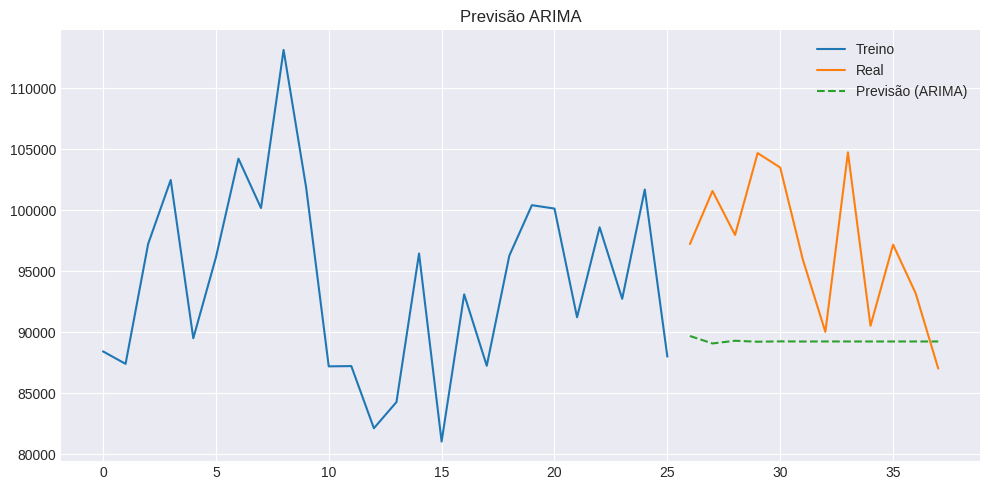

In [50]:
plt.figure(figsize=(10, 5))
plt.plot(train_time_serie.index, train_time_serie, label='Treino')
plt.plot(test_time_serie.index, test_time_serie, label='Real')
plt.plot(forecast.index, forecast, label='Previsão (ARIMA)', linestyle='--')
plt.legend()
plt.title('Previsão ARIMA')
plt.grid(True)
plt.tight_layout()
plt.show()

## Sarima

In [51]:
sarima_model = SARIMAX(train_time_serie, order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.predict(start=len(train_time_serie), end=len(train_time_serie)+11)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [52]:
mse = mean_squared_error(test_time_serie, sarima_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_time_serie, sarima_forecast)
r2 = r2_score(test_time_serie, sarima_forecast)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
metrics.append({ 'model': 'SARIMA', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 115071046.38
RMSE: 10727.12
MAE: 8622.01
R²: -2.55


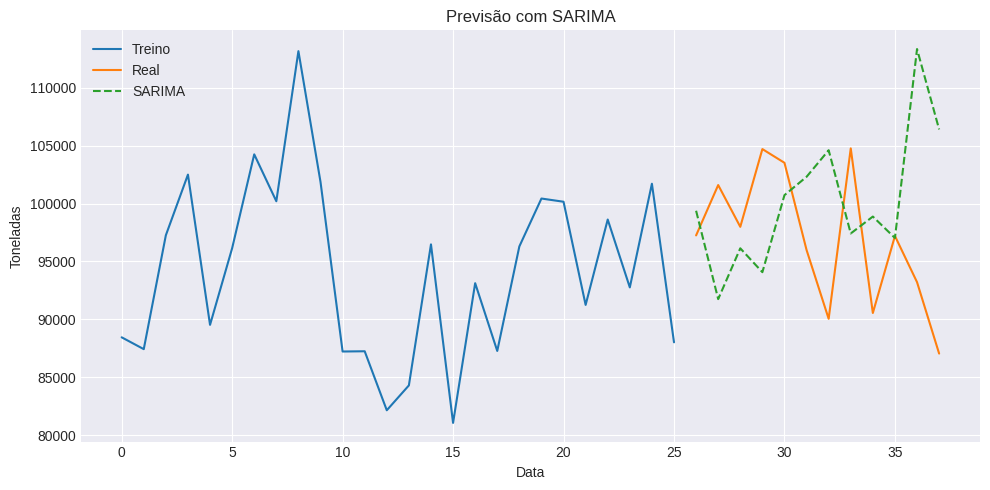

In [53]:
# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_time_serie.index, train_time_serie, label='Treino')
plt.plot(test_time_serie.index, test_time_serie, label='Real')
plt.plot(test_time_serie.index, sarima_forecast, '--', label='SARIMA')
plt.title('Previsão com SARIMA')
plt.xlabel('Data')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## SARIMAX

In [54]:
sarimax_model = SARIMAX(train_time_serie, exog=train_exog,order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_forecast = sarimax_fit.predict(start=len(train_time_serie), end=len(train_time_serie)+11, exog=test_exog)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [55]:
mse = mean_squared_error(test_time_serie, sarimax_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_time_serie, sarimax_forecast)
r2 = r2_score(test_time_serie, sarimax_forecast)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
metrics.append({ 'model': 'SARIMAX', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 84217231.02
RMSE: 9176.99
MAE: 5825.84
R²: -1.60


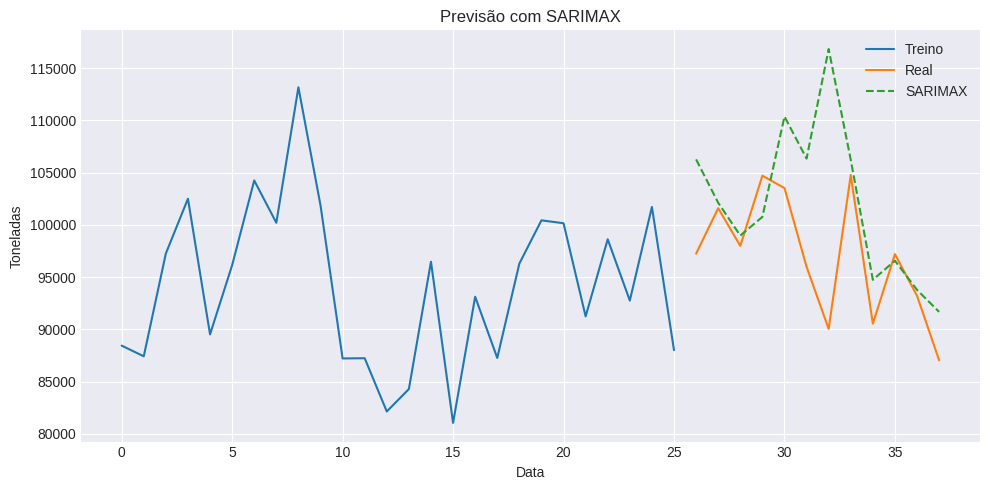

In [56]:
# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train_time_serie.index, train_time_serie, label='Treino')
plt.plot(test_time_serie.index, test_time_serie, label='Real')
plt.plot(test_time_serie.index, sarimax_forecast, '--', label='SARIMAX')
plt.title('Previsão com SARIMAX')
plt.xlabel('Data')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Prophet

In [57]:
df_prophet = pd.DataFrame({
    'ds': pd.to_datetime(time_serie['Ano'].astype(str) + '-' + time_serie['Mes'].astype(str) + '-01'),
    'y': time_serie['Toneladas']
})
train_prophet = df_prophet[:-12]
test_prophet = df_prophet[-12:]

In [58]:
prophet_model = Prophet()
prophet_model.fit(train_prophet)

02:40:22 - cmdstanpy - INFO - Chain [1] start processing
02:40:22 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
# Criar datas futuras (12 meses)
future = prophet_model.make_future_dataframe(periods=12, freq='MS')  # MS = início do mês
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']]
results = pd.merge(test_prophet, prophet_forecast, on='ds', how='left')

In [60]:
mse = mean_squared_error(results['y'], results['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(results['y'], results['yhat'])
r2 = r2_score(results['y'], results['yhat'])

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
metrics.append({ 'model': 'Prophet', 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2 })

MSE: 758569957.15
RMSE: 27542.15
MAE: 21340.52
R²: -22.42


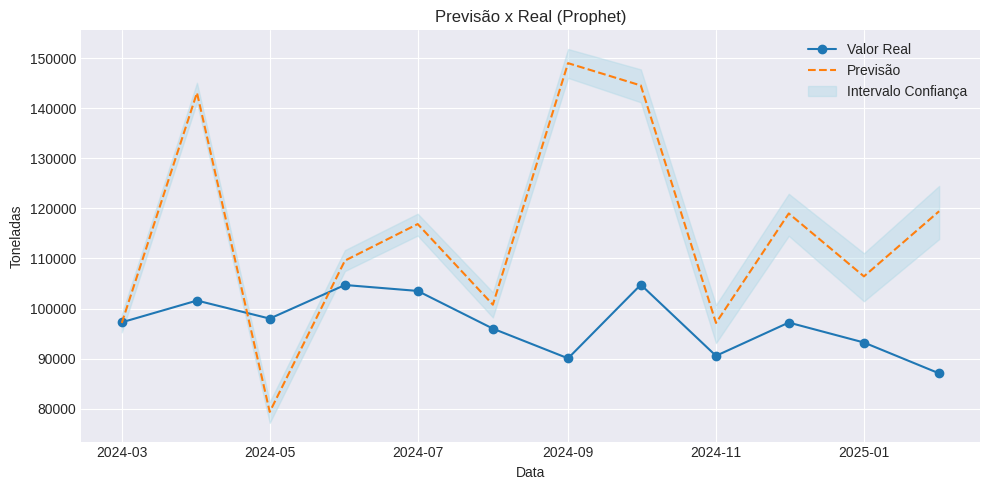

In [61]:
plt.figure(figsize=(10, 5))
plt.plot(results['ds'], results['y'], label='Valor Real', marker='o')
plt.plot(results['ds'], results['yhat'], label='Previsão', linestyle='--')
plt.fill_between(results['ds'], results['yhat_lower'], results['yhat_upper'],
                 color='lightblue', alpha=0.4, label='Intervalo Confiança')

plt.title('Previsão x Real (Prophet)')
plt.xlabel('Data')
plt.ylabel('Toneladas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Avaliação e Análise de Resultados

In [62]:
metrics = pd.DataFrame(metrics)

In [63]:
metrics

,model,mse,rmse,mae,r2
0,Random Forest,4.103658e+05,640.598041,396.457547,0.948297
1,XGBoost,3.646776e+05,603.885436,401.620940,0.954053
2,ARIMA,9.179155e+07,9580.790766,8067.842933,-1.833736
3,SARIMA,1.150710e+08,10727.117338,8622.007596,-2.552407
4,SARIMAX,8.421723e+07,9176.994662,5825.837316,-1.599906
5,Prophet,7.585700e+08,27542.148739,21340.516665,-22.418137


In [64]:
def normalize_error_metrics(series):
    min_val = series.min()
    max_val = series.max()

    if max_val == min_val:
        return pd.Series([1.0] * len(series), index=series.index)

    return 1 - ((series - min_val) / (max_val - min_val))


norm_metrics = metrics.copy()
error_metrics = ['mse', 'rmse', 'mae']

for metric in error_metrics:
    norm_metrics[metric] = normalize_error_metrics(norm_metrics[metric])
    

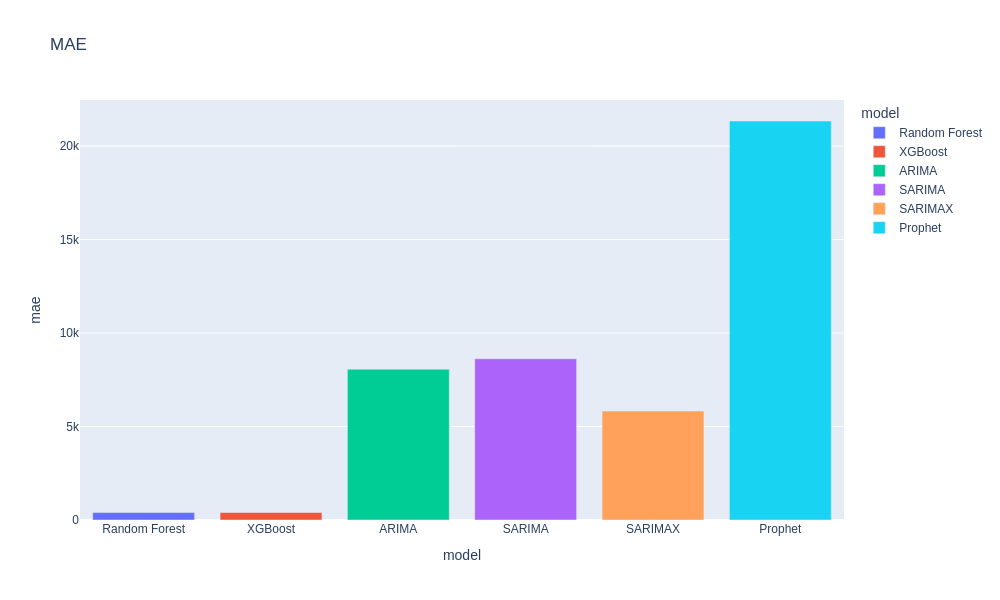

In [65]:
fig = px.bar(metrics,
            x='model',
            y='mae',
            title='MAE',
            color='model')

fig.show()

A avaliação do Erro Médio Absoluto (MAE) revela uma disparidade de performance colossal entre as duas classes de modelos. Os modelos de machine learning se mostraram altamente precisos:

* **Random Forest:** MAE de ≈ 0,39 mil toneladas

* **XGBoost:** MAE de ≈ 0,40 mil toneladas

Estes resultados contrastam de forma gritante com os dos modelos de séries temporais, cujos erros foram ordens de magnitude maiores:

* **ARIMA:** MAE de ≈ 8 mil de toneladas

* **SARIMA:** MAE de ≈ 8.6 mil de toneladas

* **SARIMAX:** MAE de ≈ 5.8 mil de toneladas

* **Prophet:** MAE de ≈ 21 mil de toneladas

Essa diferença, onde o erro dos modelos de séries temporais é mais de 20 vezes maior, demonstra a inadequação destes para a complexidade do problema e a robustez superior da abordagem de machine learning.

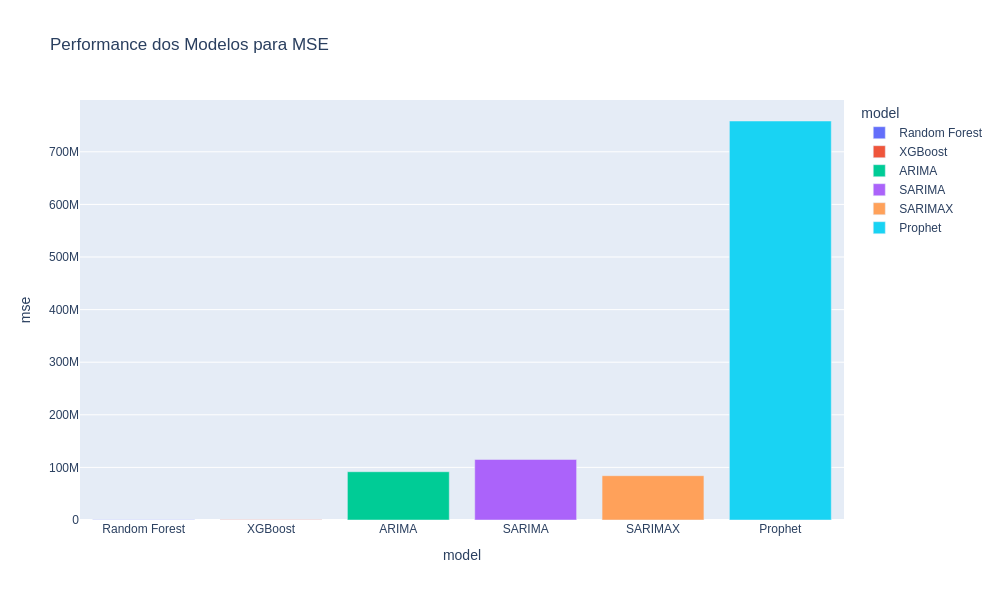

In [66]:
fig = px.bar(metrics,
             x='model',
             y='mse',
             color='model',
             title='Performance dos Modelos para MSE'
  
            )

fig.show()

O Erro Quadrático Médio (MSE) oferece uma perspectiva mais rigorosa sobre a magnitude dos erros. Como esta métrica eleva os erros ao quadrado antes de calcular a média, ela penaliza desproporcionalmente as previsões muito distantes do valor real.

Os valores de MSE extremamente altos para o Prophet indica que ele não apenas errou com frequência, mas que cometeu erros pontuais de grande magnitude, falhando catastroficamente em alguns períodos. Em contrapartida, o baixo MSE do Random Forest e XGBoost demonstra sua robustez e estabilidade.

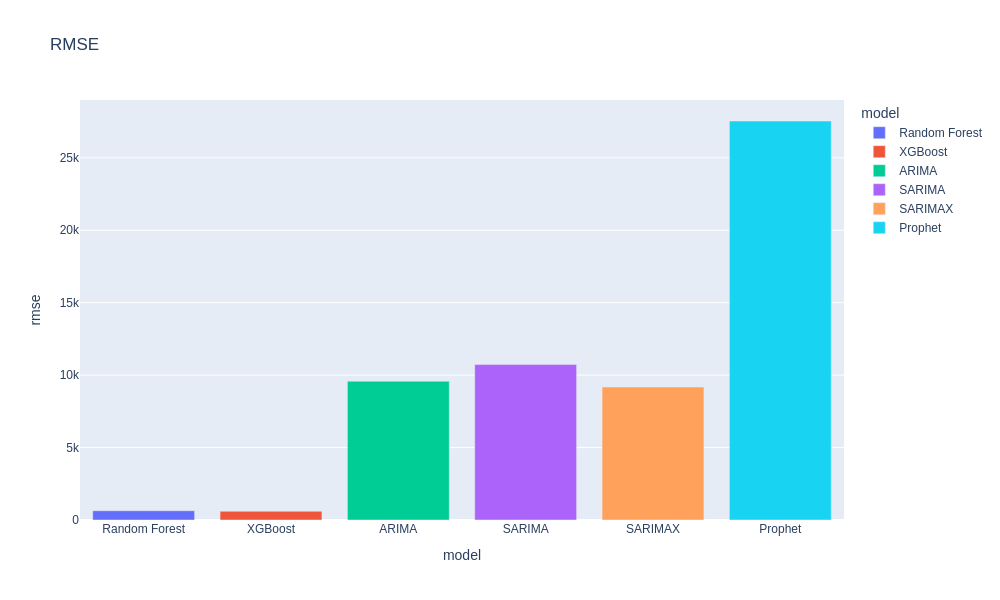

In [67]:
fig = px.bar(metrics,
            x='model',
            y='rmse',
            title='RMSE',
            color='model'
            
            )

fig.show()

A análise do RMSE (Root Mean Squared Error) é fundamental para entender a natureza dos erros do modelo. Ao penalizar erros maiores devido à sua formulação quadrática, a comparação do RMSE com o MAE nos informa sobre a consistência das previsões.

Observamos que tanto para o **Random Forest (MAE: 0,39K; RMSE: 0,64K)** quanto para o **XGBoost (MAE: 0,40K; RMSE: 0,60K)**, o valor do RMSE é consideravelmente maior que o do MAE. Essa discrepância tem um significado claro: a distribuição dos erros não é uniforme. **Existem previsões pontuais onde o erro do modelo é significativamente grande**, e são esses outliers que "puxam" o valor do RMSE para cima.

Isso caracteriza nossos melhores modelos como sendo muito precisos na média, mas suscetíveis a falhas esporádicas de maior impacto.

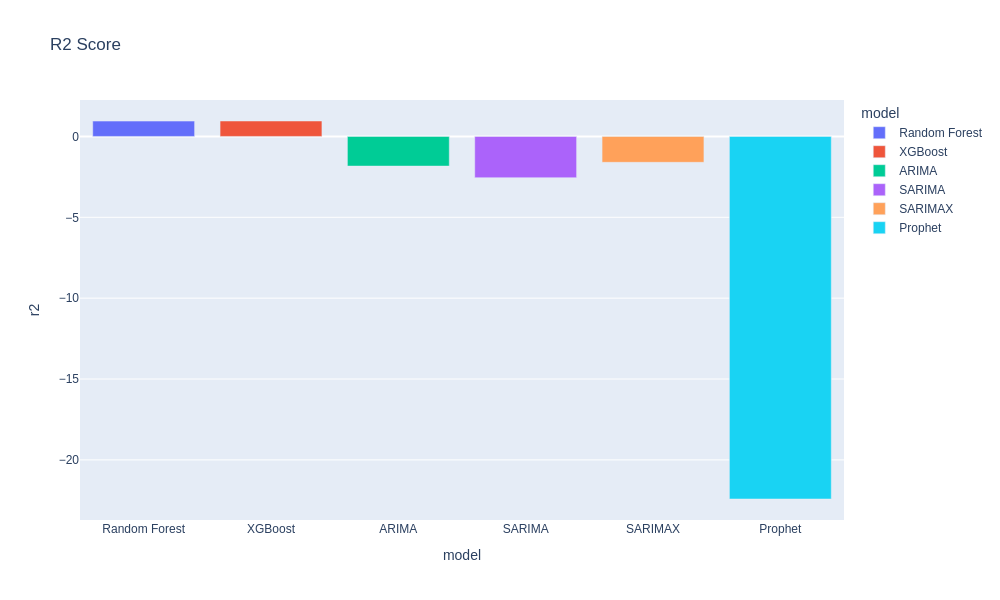

In [68]:
fig = px.bar(metrics,
            x='model',
            y='r2',
            title='R2 Score',
            color='model'
            )

fig.show()

A análise do R² (Coeficiente de Determinação) revela uma distinção clara na performance dos modelos. Random Forest e XGBoost alcançaram um R² positivo, demonstrando sua capacidade de explicar uma porção significativa da variabilidade nos dados de movimentação de cargas. Em forte contraste, os modelos de séries temporais tradicionais (ARIMA, SARIMA, SARIMAX e Prophet) resultaram em um R² negativo. Este é um indicador crítico de que o desempenho desses modelos foi inferior ao de uma simples linha de base que previsse a média histórica, apontando para um caso severo de underfitting. Embora previsões de séries temporais possam, por vezes, apresentar um R² modesto devido à alta volatilidade, um valor negativo sinaliza que a estrutura fundamental desses modelos foi inadequada para capturar os padrões complexos presentes nos dados do Porto de Santos.

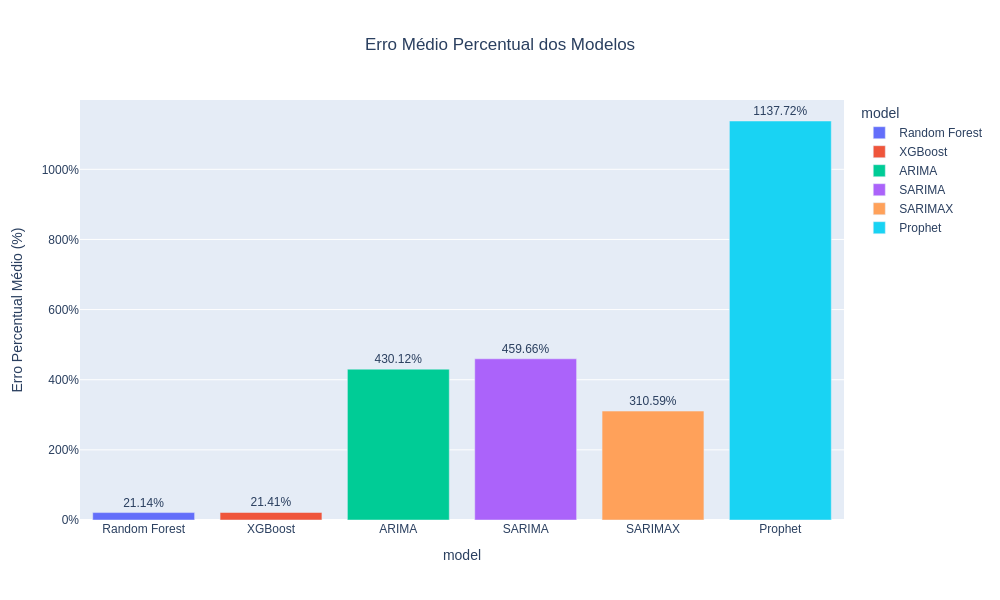

In [69]:
real_movimentation_tol = Y.mean()
mae_models = []

for model in metrics['model']:
    mae_model = metrics[metrics['model'] == model]
    percentual_mean_error = (float(mae_model['mae'].iloc[0]) / real_movimentation_tol) * 100
    mae_models.append({'model': model, 'percentual_mean_error': percentual_mean_error})

df_plot_bar = pd.DataFrame(mae_models)


fig = px.bar(df_plot_bar,
             x='model',
             y='percentual_mean_error',
             color='model',
             title='Erro Médio Percentual dos Modelos')


fig.update_traces(texttemplate='%{y:.2f}%', textposition='outside')
fig.update_yaxes(ticksuffix="%", title_text="Erro Percentual Médio (%)")


fig.update_layout(
    uniformtext_minsize=8, 
    uniformtext_mode='hide',
    title_x=0.5 
)

fig.show()

Para avaliar o impacto do erro em uma escala de negócio, foi calculado o **Erro Percentual Relativo à Média**, definido como `(MAE / Média dos Valores Reais) * 100`. Esta métrica nos permite entender o tamanho do erro médio em relação à movimentação média histórica.

A análise revelou que:
* O Random Forest apresentou um erro relativo de **21.14%**, e o XGBoost, de **21.41%**.
* Os modelos de séries temporais (ARIMA, Prophet, etc.) tiveram um erro superior a 100%, indicando que seu erro médio (MAE) foi maior que a própria média de toneladas que tentavam prever, o que os torna inviáveis.

Isso significa que o nosso melhor modelo, Random Forest, possui um erro médio que corresponde a cerca de um quarto da movimentação média, um resultado robusto para o planejamento estratégico.

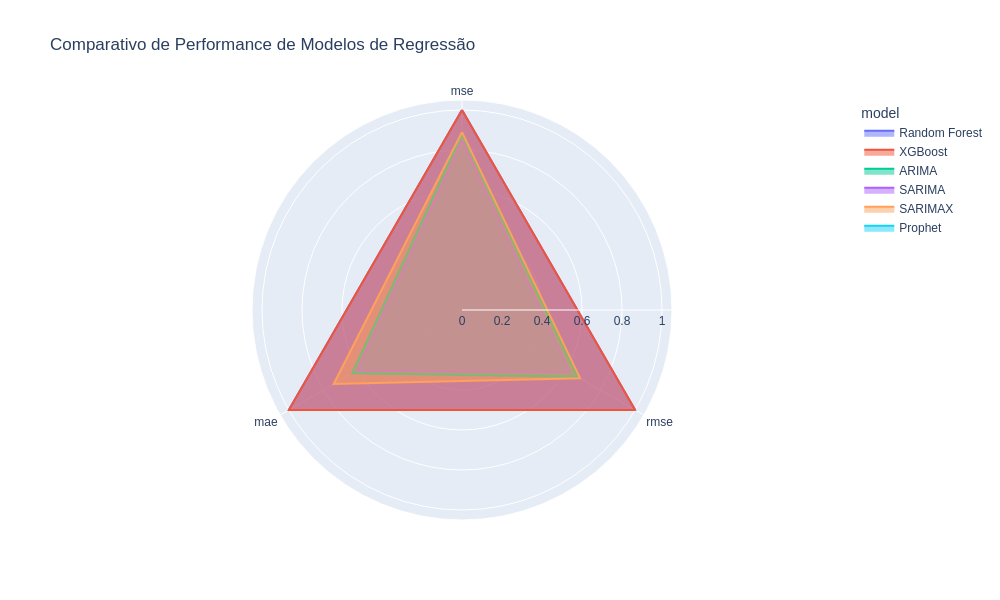

In [70]:
df_plot = pd.melt(
    norm_metrics,
    id_vars=['model'],
    value_vars=error_metrics,
    var_name='Métrica',
    value_name='Pontuação Normalizada'
)

fig = px.line_polar(
    data_frame=df_plot,
    r='Pontuação Normalizada',
    theta='Métrica',
    color='model',
    line_close=True,
    title='Comparativo de Performance de Modelos de Regressão',
    labels={'Pontuação Normalizada': 'Pontuação (0 - 1)'},
    range_r=[0, 1.05]
)

fig.update_traces(fill='toself')

fig.show()

Este gráfico de radar oferece uma visão comparativa do desempenho dos modelos em diversas métricas-chave.

**Como ler este gráfico:** Para que uma área maior sempre represente um desempenho superior, todas as métricas foram padronizadas. O R² é exibido em seu valor original (quanto maior, melhor), enquanto as métricas de erro (MSE, RMSE, MAE) foram invertidas, de modo que valores mais altos no gráfico também indicam um desempenho melhor (menor erro).

Análise:

* **Destaques:** Os modelos Random Forest e XGBoost dominam o gráfico, exibindo a maior área poligonal. Isso demonstra sua superioridade em todas as métricas avaliadas.

* **Desempenho Inferior:** Em forte contraste, o Prophet apresenta a menor área, um reflexo direto de seus altos valores de erro e baixo R².